<a href="https://colab.research.google.com/github/Rajath-55/SOP/blob/main/LSTM_SOP_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Drive setup and imports


In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
from sklearn.model_selection import train_test_split


In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
%cd json_datasets

/content/drive/MyDrive/json_datasets


### Data Preprocessing


Loading the data. 

In [5]:
#needed to open the dataset.
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 5.9 MB/s 


In [6]:
def load_data():
#load the dataset from drive.
  with open('cleaned_dataset.pickle', 'rb') as datafile:
    data = pickle.load(datafile)
  data = {k: v for k, v in data.items() if v}

  return data

def load_json():
  with open('cleaned_dataset.json', 'r') as datafile:
    return json.loads(datafile.read())

In [7]:
# remove unwanted keys:
data = load_data()

data.keys()

dict_keys(['Diplegic', 'Neuropathic', 'Normal', 'Parkinson', 'Hemiplegic'])

In [8]:
print(type(data))
# print(data)

<class 'dict'>


In [9]:
for key in data:
  print(len(data[key]))

23
23
23
23
23


In [10]:
print(data['Normal']['s1'])

{'s1normal': [[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [19.9918, 413.935], [5.38043, 543.171], [0, 0], [0, 0], [0, 0], [0, 0], [24.0811, 556.894], [24.1087, 552.976], [0, 0], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [21.9787, 413.877], [5.36647, 529.495], [0, 0], [0, 0], [0, 0], [0, 0], [39.7464, 556.853], [39.761, 551.009], [5.38539, 541.283], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [24.007, 415.866], [4.39223, 529.479], [0, 0], [0, 0], [0, 0], [0, 0], [59.2901, 554.936], [57.3337, 547.097], [5.3599, 539.328], [0, 0], [0, 0], [0, 0]], [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [29.8962, 415.915], [25.9983, 537.291], [0, 0], [0, 0], [0, 0], [0, 0], [82.7402, 554.927], [76.9089, 549.04],

In [11]:
print(data['Normal'].keys())

dict_keys(['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's3', 's4', 's5', 's6', 's7', 's8', 's9'])


### Preparing the dataset.
Time-series data of coordinates for each subject is passed. We take the json data and convert it into appropriate 1d vectors of 50 coordinates.

In [12]:
import glob

labels = ['Diplegic', 'Neuropathic', 'Normal', 'Parkinsonian', 'Hemiplegic']


def prepare_dataset():
  
  # make the dataset into the form (x+y)*timesteps
  label_data = []
  for gait in data:
    print(gait)
    
    subjects = []
    for subject in data[gait]:
      subject_data = []
      key = list(data[gait][subject].keys())[0]
      for k in data[gait][subject][key]:
        #flatten each coordinate list (25 coordinates as of now) into a 1D vector
        if len(k):
          subject_data.append(np.asarray(k, dtype=np.float32).flatten())
      # subject_data = np.array(subject_data, dtype=np.float32)
      # if subject_data.shape == (0,):
        #we do not have temporal data in this case:
        # print(subject + ' ' + gait + ' ' + key) 
      subjects.append(subject_data)
    label_data.append(subjects)

  return label_data
    

   

Save the processed data as a pickle file to be loaded later.

In [13]:

def save_dumpfile():
  processed_data = prepare_dataset()
  with open('processed_data_v1.pickle', 'wb') as dumpfile:
    pickle.dump(processed_data, dumpfile, protocol=pickle.HIGHEST_PROTOCOL )

  
  



In [14]:
save_dumpfile()


Diplegic
Neuropathic
Normal
Parkinson
Hemiplegic


### LSTM Model


In [15]:
def get_model():
  input_shape = (1, 50)
  classifier = tf.keras.Sequential()
  classifier.add(tf.keras.Input(shape = input_shape))
  classifier.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)))
  # classifier.add(tf.keras.layers.Dense(64))
  # classifier.add(tf.keras.layers.Dropout(0.2))
  classifier.add(tf.keras.layers.Dense(32))
  classifier.add(tf.keras.layers.Dense(5, activation='softmax'))
  return classifier

def test_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True), input_shape=(1, 50)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)))
  model.add(tf.keras.layers.Dense(32))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(5))
  model.add(tf.keras.layers.Activation('softmax'))
  # model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
  return model

In [16]:
model = get_model()

model.summary()
model.compile(tf.keras.optimizers.Adam(learning_rate = 3e-4), "categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 43,797
Trainable params: 43,797
Non-trainable params: 0
_________________________________________________________________


### Loading preprocessed dataset and analysis

In [17]:
preprocessed = prepare_dataset()

Diplegic
Neuropathic
Normal
Parkinson
Hemiplegic


In [18]:
print(len(preprocessed))
print(len(preprocessed[0]))
print(len(preprocessed[0][0]))
print(len(preprocessed[0][0][0]))

5
23
2095
50


### Making the dataframe from preprocessed data

In [19]:
for i in range(0,50):
  print(f"preprocessed[i][j][k][{i}],", end=' ')

preprocessed[i][j][k][0], preprocessed[i][j][k][1], preprocessed[i][j][k][2], preprocessed[i][j][k][3], preprocessed[i][j][k][4], preprocessed[i][j][k][5], preprocessed[i][j][k][6], preprocessed[i][j][k][7], preprocessed[i][j][k][8], preprocessed[i][j][k][9], preprocessed[i][j][k][10], preprocessed[i][j][k][11], preprocessed[i][j][k][12], preprocessed[i][j][k][13], preprocessed[i][j][k][14], preprocessed[i][j][k][15], preprocessed[i][j][k][16], preprocessed[i][j][k][17], preprocessed[i][j][k][18], preprocessed[i][j][k][19], preprocessed[i][j][k][20], preprocessed[i][j][k][21], preprocessed[i][j][k][22], preprocessed[i][j][k][23], preprocessed[i][j][k][24], preprocessed[i][j][k][25], preprocessed[i][j][k][26], preprocessed[i][j][k][27], preprocessed[i][j][k][28], preprocessed[i][j][k][29], preprocessed[i][j][k][30], preprocessed[i][j][k][31], preprocessed[i][j][k][32], preprocessed[i][j][k][33], preprocessed[i][j][k][34], preprocessed[i][j][k][35], preprocessed[i][j][k][36], preprocesse

In [20]:
df = pd.DataFrame()

In [21]:
labels = ['Diplegic', 'Neuropathic', 'Normal', 'Parkinsonian', 'Hemiplegic']


Making a dataframe from all the data we have, by making 2D Lists of appropriate columns and rows and then converting them into df.

In [22]:
my_list = []

for i in range(len(preprocessed)):
  print(f"_______LABEL{i}_______")
  for j in range(len(preprocessed[i])):
    print(f"_______Subject{j}_______")
    for k in range(len(preprocessed[i][j])):
      if k % 200 == 0:
        print(f"________Timeseries{k}_________")
      #df = df.append([prepared[i][j][k][0], prepared[i][j][k][1], prepared[i][j][k][2], prepared[i][j][k][3], prepared[i][j][k][4], prepared[i][j][k][5], prepared[i][j][k][6], prepared[i][j][k][7], prepared[i][j][k][8], prepared[i][j][k][9], prepared[i][j][k][10], prepared[i][j][k][11], prepared[i][j][k][12], prepared[i][j][k][13], prepared[i][j][k][14], prepared[i][j][k][15], prepared[i][j][k][16], prepared[i][j][k][17], prepared[i][j][k][18], prepared[i][j][k][19], prepared[i][j][k][20], prepared[i][j][k][21], prepared[i][j][k][22], prepared[i][j][k][23], prepared[i][j][k][24], prepared[i][j][k][25], prepared[i][j][k][26], prepared[i][j][k][27], prepared[i][j][k][28], prepared[i][j][k][29], prepared[i][j][k][30], prepared[i][j][k][31], prepared[i][j][k][32], prepared[i][j][k][33], prepared[i][j][k][34], prepared[i][j][k][35], prepared[i][j][k][36], prepared[i][j][k][37], prepared[i][j][k][38], prepared[i][j][k][39], prepared[i][j][k][40], prepared[i][j][k][41], prepared[i][j][k][42], prepared[i][j][k][43], prepared[i][j][k][44], prepared[i][j][k][45], prepared[i][j][k][46], prepared[i][j][k][47], prepared[i][j][k][48], prepared[i][j][k][49], k, j, labels[i]])
      my_list.append([preprocessed[i][j][k][0], preprocessed[i][j][k][1], preprocessed[i][j][k][2], preprocessed[i][j][k][3], preprocessed[i][j][k][4], preprocessed[i][j][k][5], preprocessed[i][j][k][6], preprocessed[i][j][k][7], preprocessed[i][j][k][8], preprocessed[i][j][k][9], preprocessed[i][j][k][10], preprocessed[i][j][k][11], preprocessed[i][j][k][12], preprocessed[i][j][k][13], preprocessed[i][j][k][14], preprocessed[i][j][k][15], preprocessed[i][j][k][16], preprocessed[i][j][k][17], preprocessed[i][j][k][18], preprocessed[i][j][k][19], preprocessed[i][j][k][20], preprocessed[i][j][k][21], preprocessed[i][j][k][22], preprocessed[i][j][k][23], preprocessed[i][j][k][24], preprocessed[i][j][k][25], preprocessed[i][j][k][26], preprocessed[i][j][k][27], preprocessed[i][j][k][28], preprocessed[i][j][k][29], preprocessed[i][j][k][30], preprocessed[i][j][k][31], preprocessed[i][j][k][32], preprocessed[i][j][k][33], preprocessed[i][j][k][34], preprocessed[i][j][k][35], preprocessed[i][j][k][36], preprocessed[i][j][k][37], preprocessed[i][j][k][38], preprocessed[i][j][k][39], preprocessed[i][j][k][40], preprocessed[i][j][k][41], preprocessed[i][j][k][42], preprocessed[i][j][k][43], preprocessed[i][j][k][44], preprocessed[i][j][k][45], preprocessed[i][j][k][46], preprocessed[i][j][k][47], preprocessed[i][j][k][48], preprocessed[i][j][k][49], k, j, i])


_______LABEL0_______
_______Subject0_______
________Timeseries0_________
________Timeseries200_________
________Timeseries400_________
________Timeseries600_________
________Timeseries800_________
________Timeseries1000_________
________Timeseries1200_________
________Timeseries1400_________
________Timeseries1600_________
________Timeseries1800_________
________Timeseries2000_________
_______Subject1_______
________Timeseries0_________
________Timeseries200_________
________Timeseries400_________
________Timeseries600_________
________Timeseries800_________
________Timeseries1000_________
________Timeseries1200_________
________Timeseries1400_________
________Timeseries1600_________
________Timeseries1800_________
________Timeseries2000_________
________Timeseries2200_________
________Timeseries2400_________
________Timeseries2600_________
_______Subject2_______
________Timeseries0_________
________Timeseries200_________
________Timeseries400_________
________Timeseries600_________
__

In [23]:
print(len(my_list))
print(len(my_list[0]))

242554
53


In [24]:
df = pd.DataFrame(my_list, columns=['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'keyframe', 'subject', 'label'])

In [25]:
df.tail(50)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c44,c45,c46,c47,c48,c49,c50,keyframe,subject,label
242504,0.0,0.0,35.747601,180.714996,25.974300,180.667007,0.000000,0.000000,0.000000,0.000000,...,554.859985,27.907801,558.849976,29.917200,554.956970,88.749901,549.030029,2070,22,4
242505,0.0,0.0,29.903999,180.694000,24.047300,178.811996,0.000000,0.000000,0.000000,0.000000,...,550.968994,26.030001,558.862000,29.913700,554.969971,88.723602,549.080994,2071,22,4
242506,0.0,0.0,24.081200,180.692001,22.013800,178.772995,0.000000,0.000000,0.000000,0.000000,...,545.150024,27.896299,558.849976,31.828600,554.960022,88.714203,547.130981,2072,22,4
242507,0.0,0.0,24.003799,178.850006,22.000900,178.703995,0.000000,0.000000,0.000000,0.000000,...,541.197998,27.899799,558.862976,31.846800,554.969971,88.745598,545.184998,2073,22,4
242508,0.0,0.0,22.103100,178.809998,22.025499,174.878006,0.000000,0.000000,0.000000,0.000000,...,539.190002,26.032801,558.851990,31.868500,554.971008,88.755600,547.106018,2074,22,4
242509,0.0,0.0,22.122801,178.746002,25.980301,170.942001,0.000000,0.000000,0.000000,0.000000,...,535.333008,27.905100,558.838013,33.765598,554.945984,88.658401,545.172974,2075,22,4
242510,0.0,0.0,22.107599,178.764008,29.864500,169.016006,0.000000,0.000000,0.000000,0.000000,...,529.479980,26.028000,558.825012,31.871599,554.960022,88.633003,547.091003,2076,22,4
242511,0.0,0.0,20.094101,178.832001,27.910400,170.934006,0.000000,0.000000,0.000000,0.000000,...,529.453003,27.914301,558.814026,33.767200,554.939026,86.728302,547.101013,2077,22,4
242512,0.0,0.0,20.082300,178.761993,31.824100,170.925003,65.140297,257.132996,0.000000,0.000000,...,527.489014,27.911900,556.992004,31.818899,554.906006,86.610497,549.052979,2078,22,4
242513,0.0,0.0,20.077600,178.744003,35.750900,174.830994,69.018501,257.074005,0.000000,0.000000,...,0.000000,27.898300,556.976990,31.861000,554.916016,84.660500,552.950012,2079,22,4


Save the dataset for future reference.

In [26]:
df.to_csv('Dataset.csv')

Loading the dataset from drive.

In [27]:
df = pd.read_csv('Dataset.csv')

In [28]:
df

,Unnamed: 0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c44,c45,c46,c47,c48,c49,c50,keyframe,subject,label
0,0,5.35017,133.671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,1,5.35043,133.732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2,2,5.34529,133.788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0
3,3,14.19570,133.629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0
4,4,20.06840,131.838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242549,242549,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,517.683,0.0,0.0,0.0,0.0,0.0,0.0,2115,22,4
242550,242550,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,515.758,0.0,0.0,0.0,0.0,0.0,0.0,2116,22,4
242551,242551,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,513.828,0.0,0.0,0.0,0.0,0.0,0.0,2117,22,4
242552,242552,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,515.745,0.0,0.0,0.0,0.0,0.0,0.0,2118,22,4


The y_train dataset will include label as the y data, but one hot encoded (done later)

In [29]:
y = df['label']

Drop unnecessary columns from the dataframe

In [30]:
x = df.drop(columns=['label', 'keyframe', 'subject'], axis=1)

In [31]:
x = x.drop(columns=['Unnamed: 0'])

In [32]:
x

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50
0,5.35017,133.671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,5.35043,133.732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,5.34529,133.788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,14.19570,133.629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,20.06840,131.838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242549,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0607,545.116,53.3140,517.683,0.0,0.0,0.0,0.0,0.0,0.0
242550,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.1138,541.245,43.6049,515.758,0.0,0.0,0.0,0.0,0.0,0.0
242551,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0494,539.262,39.6933,513.828,0.0,0.0,0.0,0.0,0.0,0.0
242552,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.1854,539.221,35.7566,515.745,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y

0         0
1         0
2         0
3         0
4         0
         ..
242549    4
242550    4
242551    4
242552    4
242553    4
Name: label, Length: 242554, dtype: int64

Convert y into one-hot encoded array 

In [34]:
y_new = tf.keras.utils.to_categorical(y, 5)

In [35]:
y_new

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Save the data on drive for future reference.

In [36]:
x.to_csv('X_data.csv')
y_new = pd.DataFrame(y_new)
y_new.to_csv('Y_data.csv')

### Reading and cleaning saved train data

In [37]:
x = pd.read_csv('X_data.csv')
y = pd.read_csv('Y_data.csv')

In [38]:
x

,Unnamed: 0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50
0,0,5.35017,133.671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5.35043,133.732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5.34529,133.788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,14.19570,133.629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,4,20.06840,131.838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242549,242549,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0607,545.116,53.3140,517.683,0.0,0.0,0.0,0.0,0.0,0.0
242550,242550,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.1138,541.245,43.6049,515.758,0.0,0.0,0.0,0.0,0.0,0.0
242551,242551,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0494,539.262,39.6933,513.828,0.0,0.0,0.0,0.0,0.0,0.0
242552,242552,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.1854,539.221,35.7566,515.745,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
y

,Unnamed: 0,0,1,2,3,4
0,0,1.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
242549,242549,0.0,0.0,0.0,0.0,1.0
242550,242550,0.0,0.0,0.0,0.0,1.0
242551,242551,0.0,0.0,0.0,0.0,1.0
242552,242552,0.0,0.0,0.0,0.0,1.0


CSV file loading causes a new column Unnamed: 0 to appear, so we drop it again.


In [40]:
x = x.drop(columns = ['Unnamed: 0'], axis = 1)
y = y.drop(columns = ['Unnamed: 0'], axis = 1)

In [41]:
x

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50
0,5.35017,133.671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,5.35043,133.732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,5.34529,133.788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,14.19570,133.629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,20.06840,131.838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242549,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0607,545.116,53.3140,517.683,0.0,0.0,0.0,0.0,0.0,0.0
242550,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.1138,541.245,43.6049,515.758,0.0,0.0,0.0,0.0,0.0,0.0
242551,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0494,539.262,39.6933,513.828,0.0,0.0,0.0,0.0,0.0,0.0
242552,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.1854,539.221,35.7566,515.745,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
y

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
242549,0.0,0.0,0.0,0.0,1.0
242550,0.0,0.0,0.0,0.0,1.0
242551,0.0,0.0,0.0,0.0,1.0
242552,0.0,0.0,0.0,0.0,1.0


Convert y to an np array for one hot encoding to work

In [43]:
y = np.array(y)

In [44]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Train test split, and reshaping into model dimensions.





In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

Convert x_train to an np array to reshape it into the dimensions that the model requires.

In [46]:
X_train = np.array(X_train)
X_test = np.array(X_test)

The shape the model expects is a 3D tensor of shape (None, 1, 50). So we reshape it into that size, where X_train.shape[0] is the dynamic timestep size, and the other sizes are constant and show length and features.

In [47]:
X_train_new = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_new = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### Checking something out


In [48]:
# split into samples (e.g. 5000/200 = 25)
samples = list()
length = 50
n = len(X_train)
# step over the 5,000 in jumps of 50
for i in range(0,n,length):
	sample = X_train_new[i:i+length]
	samples.append(sample)

samples


[array([[[ 462.826,  137.611,  398.281, ...,  588.302,  302.161,
           590.267]],
 
        [[ 186.641,  149.42 ,  263.068, ...,  556.965,  421.747,
           541.28 ]],
 
        [[1079.99 ,  149.432, 1134.91 , ...,  556.906, 1185.82 ,
           525.63 ]],
 
        ...,
 
        [[   0.   ,    0.   , 1226.95 , ...,  556.915, 1228.93 ,
           554.846]],
 
        [[1132.89 ,  164.98 , 1052.57 , ...,  588.258,  993.692,
           586.235]],
 
        [[ 368.778,  176.829,  300.274, ...,  586.316,  215.973,
           574.571]]]),
 array([[[1197.61   ,  225.76   , 1250.45   , ...,  554.84   ,
          1238.67   ,  549.064  ]],
 
        [[1040.87   ,  123.94   , 1072.15   , ...,  556.854  ,
          1154.41   ,  539.315  ]],
 
        [[   5.37596,  229.711  ,   51.4175 , ...,  556.911  ,
           119.985  ,  556.825  ]],
 
        ...,
 
        [[ 370.738  ,  108.232  ,  419.767  , ...,  568.597  ,
           460.919  ,  560.804  ]],
 
        [[ 572.503  ,  137.609  

In [49]:
X_train_f = X_train[:194000]
y_train_f = y_train[:194000]
X_train_checking = X_train_f.reshape(X_train_f.shape[0]//50, 50, X_train.shape[1])
X_train_checking.shape

(3880, 50, 50)

### Training the Model. 

Training the model with 40 epochs, early stopping and Learning Rate Scheduling 


In [51]:

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                               patience=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
)
def scheduler(epoch, lr):
    if epoch < 10:
       return lr
    else:
       return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [early_stopping,lr_scheduler]


history = model.fit(X_train_new, y_train, epochs = 40, callbacks = callbacks, validation_split = 0.2, batch_size = 8)
# history = model.fit(X_train_checking, y_train_f, epochs = 40, callbacks = callbacks, validation_split = 0.2, batch_size = 8, shuffle = False)

Epoch 1/40
19405/19405 [==============================] - 160s 8ms/step - loss: 1.4493 - accuracy: 0.3325 - val_loss: 1.3898 - val_accuracy: 0.3636 - lr: 3.0000e-04
Epoch 2/40
19405/19405 [==============================] - 156s 8ms/step - loss: 1.3839 - accuracy: 0.3709 - val_loss: 1.4323 - val_accuracy: 0.3531 - lr: 3.0000e-04
Epoch 3/40
19405/19405 [==============================] - 153s 8ms/step - loss: 1.3499 - accuracy: 0.3866 - val_loss: 1.2992 - val_accuracy: 0.4178 - lr: 3.0000e-04
Epoch 4/40
19405/19405 [==============================] - 158s 8ms/step - loss: 1.3303 - accuracy: 0.3961 - val_loss: 1.3225 - val_accuracy: 0.4013 - lr: 3.0000e-04
Epoch 5/40
19405/19405 [==============================] - 155s 8ms/step - loss: 1.3063 - accuracy: 0.4028 - val_loss: 1.2893 - val_accuracy: 0.3964 - lr: 3.0000e-04
Epoch 6/40
19405/19405 [==============================] - 149s 8ms/step - loss: 1.2866 - accuracy: 0.4139 - val_loss: 1.3215 - val_accuracy: 0.3924 - lr: 3.0000e-04
Epoch 7/40

### Plotting the loss and accuracy 

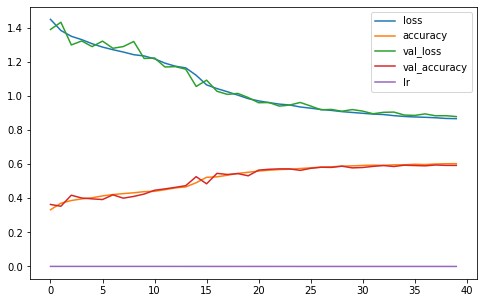

In [52]:
import matplotlib.pyplot as plt

plot = pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# model.save('bilstmmanydense_66perc.h5')

In [53]:
model.evaluate(X_test_new, y_test, batch_size = 8)

6064/6064 [==============================] - 24s 4ms/step - loss: 0.8776 - accuracy: 0.5956


[0.877627968788147, 0.59563809633255]

In [54]:
y_pred = model.predict(X_test_new)
classes_x=np.argmax(y_pred,axis=1)


In [55]:
classes_x[1:23]

array([3, 3, 1, 0, 0, 0, 3, 4, 2, 2, 4, 2, 4, 0, 3, 3, 3, 1, 0, 1, 4, 4])

In [56]:
classes_pred = [labels[i] for i in classes_x]

In [57]:
classes_pred

['Normal',
 'Parkinsonian',
 'Parkinsonian',
 'Neuropathic',
 'Diplegic',
 'Diplegic',
 'Diplegic',
 'Parkinsonian',
 'Hemiplegic',
 'Normal',
 'Normal',
 'Hemiplegic',
 'Normal',
 'Hemiplegic',
 'Diplegic',
 'Parkinsonian',
 'Parkinsonian',
 'Parkinsonian',
 'Neuropathic',
 'Diplegic',
 'Neuropathic',
 'Hemiplegic',
 'Hemiplegic',
 'Normal',
 'Hemiplegic',
 'Parkinsonian',
 'Hemiplegic',
 'Parkinsonian',
 'Parkinsonian',
 'Neuropathic',
 'Hemiplegic',
 'Diplegic',
 'Hemiplegic',
 'Hemiplegic',
 'Diplegic',
 'Diplegic',
 'Neuropathic',
 'Hemiplegic',
 'Hemiplegic',
 'Hemiplegic',
 'Hemiplegic',
 'Normal',
 'Normal',
 'Parkinsonian',
 'Parkinsonian',
 'Diplegic',
 'Neuropathic',
 'Neuropathic',
 'Diplegic',
 'Diplegic',
 'Diplegic',
 'Neuropathic',
 'Parkinsonian',
 'Normal',
 'Hemiplegic',
 'Diplegic',
 'Normal',
 'Diplegic',
 'Neuropathic',
 'Hemiplegic',
 'Diplegic',
 'Neuropathic',
 'Parkinsonian',
 'Parkinsonian',
 'Diplegic',
 'Diplegic',
 'Diplegic',
 'Parkinsonian',
 'Diplegic',